<a href="https://colab.research.google.com/github/Jmmostafa/QuantRisk/blob/main/QR004_OptionsVolatilityModelsII.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Volatility Surface II**

|  |  |
|:---|:---|
|**Developed By** |  Md Mostafa Kamal |
|**Date** | June 10, 2025  |
|**Covered** | Options Volatlity Smoothing, Local & Stochastic Volatility, Application |
|**Sequence** | QR004 |


---

# **Introduction**

As you may noticed that there are some issues in our previous plain vanilla model for implied volatility. In this notebook, I will be trying to update the perfomances to match the volatility using the following models:

- **Parametric Model:** Constant Elasticity of Variance (CEV)
- **Non-parametric Model:** Dupire's Local Volatility Model (DLV)
- **Stochastic Model:** Stochastic Alpha Beta Rho Model (SABR)

In subsequent sections, we will:
- Introduce incremental refinements to the base model
- Address limitations through model extensions
- Enhance estimation accuracy with more sophisticated approaches

This progressive exploration will demonstrate how advanced techniques build upon the Black-Scholes framework to better capture market realities.


# **Option Pricing Model (BS Model)**
The **Black-Scholes (BS) model** (1973) is a mathematical framework for pricing European-style options. It assumes:
- Geometric Brownian motion for stock prices
- Constant volatility (σ) and risk-free rate (r)
- No dividends
- Efficient markets

BS model computes the prices of the options as

### Call Option Price:
$$
C(S_t, K, T, r, \sigma) = S_tN(d_1) - Ke^{-rT}N(d_2)
$$

### Put Option Price:
$$
P(S_t, K, T, r, \sigma) = Ke^{-rT}N(-d_2) - S_tN(-d_1)
$$

- Where:
$$
d_1 = \frac{\ln(S_t/K) + (r + \sigma^2/2)T}{\sigma\sqrt{T}} \\
d_2 = d_1 - \sigma\sqrt{T}
$$

- $S_t$ = Current stock price
- $K$ = Strike price
- $T$ = Time to expiration (years)
- $r$ = Risk-free rate
- $\sigma$ = Volatility
- $N$ = Standard normal CDF

### Limitations
- Assumes log-normal returns (underestimates tail risk)
- Constant volatility (contrary to "volatility smile" observed in markets)
- No early exercise (invalid for American options)

## Implied Volatility (IV)

- **The market's forecast** of how much a stock/asset might move
- **Embedded in option prices** - higher IV = more expensive options
- **Not actual volatility** (it's what traders *expect* will happen)

### **Dynamics**  
   - Changes constantly based on:
     - Market fear/greed
     - Upcoming events (earnings, Fed decisions)
     - Supply/demand for options

- **Options pricing**: Higher IV → more expensive options  
- **Trading signals**:  
  - High IV = potential overpriced options (sell opportunities)  
  - Low IV = potential underpriced options (buy opportunities)

In [298]:
!pip install yfinance numpy scipy matplotlib scienceplots --quiet
!apt-get install texlive-latex-extra texlive-fonts-recommended dvipng cm-super --quiet


# For latex text in the graphs
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "text.latex.preamble": r"\usepackage{amsmath}"
})

Reading package lists...
Building dependency tree...
Reading state information...
cm-super is already the newest version (0.3.4-17).
dvipng is already the newest version (1.15-1.1).
texlive-fonts-recommended is already the newest version (2021.20220204-1).
texlive-latex-extra is already the newest version (2021.20220204-1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [299]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import brentq
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import scienceplots

# Helper function to get next Friday's date
def next_friday():
    today = datetime.today()
    days_to_friday = (4 - today.weekday()) % 7  # Friday is weekday 4
    if days_to_friday == 0:  # If today is Friday, get next Friday
        days_to_friday = 7
    return (today + timedelta(days=days_to_friday)).strftime('%Y-%m-%d')

# Get live data
aapl = yf.Ticker("AAPL")
expiry_date = next_friday()
opt = aapl.option_chain(expiry_date)
calls = opt.calls.dropna(subset=['lastPrice'])

# Market parameters
S = aapl.history(period="1d")["Close"].iloc[-1]
r = 0.0439
expiry_datetime = pd.to_datetime(expiry_date)
T = (expiry_datetime - pd.Timestamp.now()).total_seconds() / (365 * 24 * 3600)

# Black-Scholes pricing function
def black_scholes(S, K, T, r, sigma, option_type):
    if T <= 0 or sigma <= 0:
        return 0
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    if option_type == 'call':
        return S * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)
    else:
        return K * np.exp(-r*T) * norm.cdf(-d2) - S * norm.cdf(-d1)

# Implied volatility calculation
def implied_vol(S, K, T, r, market_price, option_type):
    def objective(sigma):
        return black_scholes(S, K, T, r, sigma, option_type) - market_price
    try:
        return brentq(objective, 1e-5, 3.0)
    except (ValueError, RuntimeError):
        return np.nan

# Calculate IV for top 100 strikes
iv_results = []
valid_strikes = calls.strike.unique()#[:100]

for K in valid_strikes:
    strike_data = calls[calls.strike == K]
    market_price = strike_data['lastPrice'].mean()
    market_iv = strike_data['impliedVolatility'].mean()

    if market_price > 0 and not np.isnan(market_price):
        calculated_iv_BS = implied_vol(S, K, T, r, market_price, 'call')
        iv_results.append({
            'Strike': K,
            'Price': market_price,
            'Market_IV': market_iv,
            'BS_IV': calculated_iv_BS if not np.isnan(calculated_iv_BS) else None,
            'Moneyness': 'ITM' if K < S else ('OTM' if K > S else 'ATM')
        })

# Create and display results
iv_df = pd.DataFrame(iv_results).dropna()
iv_df.head()

,Strike,Price,Market_IV,BS_IV,Moneyness
32,165.0,32.00,1.123051,2.750178,ITM
35,175.0,21.95,0.871095,1.923835,ITM
36,177.5,19.10,0.839845,0.981945,ITM
37,180.0,16.95,0.673831,1.546377,ITM
38,182.5,14.15,0.679691,0.951282,ITM


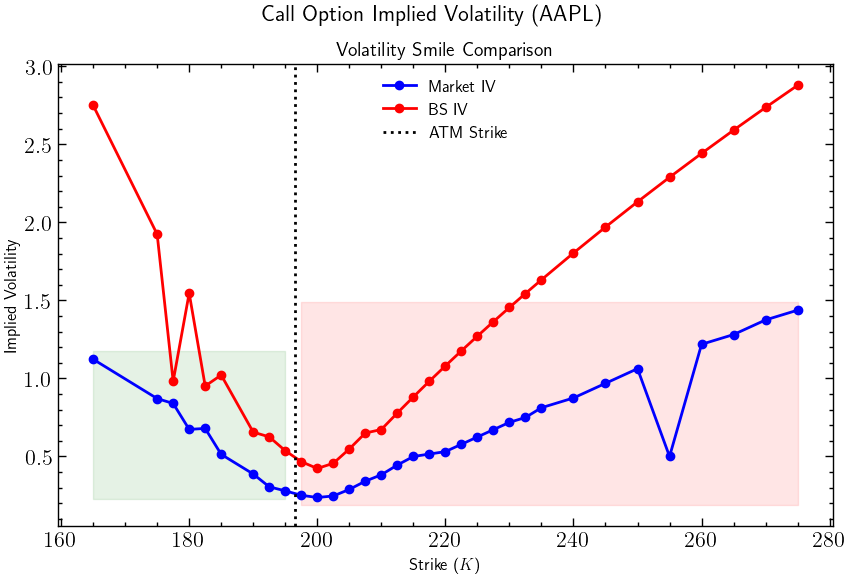

In [300]:
# Comparing the market IV with the calculated IV
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science', 'notebook', 'grid'])
plt.figure(figsize=(10, 6))
plt.rcParams['text.usetex'] = True

# Plotting
plt.plot(iv_df['Strike'], iv_df['Market_IV'], 'b-o', label='Market IV', linewidth=2)
plt.plot(iv_df['Strike'], iv_df['BS_IV'], 'r-o', label='BS IV', linewidth=2)
plt.axvline(x=S, color='k', linestyle=':', label='ATM Strike')

# Formatting
plt.suptitle('Call Option Implied Volatility (AAPL)', fontsize=16)
plt.title('Volatility Smile Comparison', fontsize=14)
plt.xlabel('Strike ($K$)', fontsize=12)
plt.ylabel('Implied Volatility', fontsize=12)
plt.legend(frameon = False, fontsize=12)
plt.grid(False)

# Moneyness coloring
itm = iv_df[iv_df['Moneyness'] == 'ITM']
atm = iv_df[iv_df['Moneyness'] == 'ATM']
otm = iv_df[iv_df['Moneyness'] == 'OTM']

plt.fill_between(itm['Strike'], itm['Market_IV'].min()-0.05, itm['Market_IV'].max()+0.05,
                 color='green', alpha=0.1, label='ITM Zone')
plt.fill_between(otm['Strike'], otm['Market_IV'].min()-0.05, otm['Market_IV'].max()+0.05,
                 color='red', alpha=0.1, label='OTM Zone')

plt.show()

# **Volatility Models**

These models address key limitations of Black-Scholes by capturing **real-world market dynamics**:  
- **CEV** introduces a flexible price-volatility relationship via the elasticity parameter ($\beta$) to model leverage effects.  
- **Dupire's Local Volatility** provides a **perfect fit to market prices** by deriving a deterministic volatility surface from observed option prices, enabling consistent pricing of exotics.
- **SABR** combines **stochastic volatility** and local dynamics to better capture the volatility smile/skew, especially in rates markets.  

While Black-Scholes assumes constant volatility, these models refine pricing/hedging by accounting for **non-flat volatility surfaces** and **time-varying market conditions**.

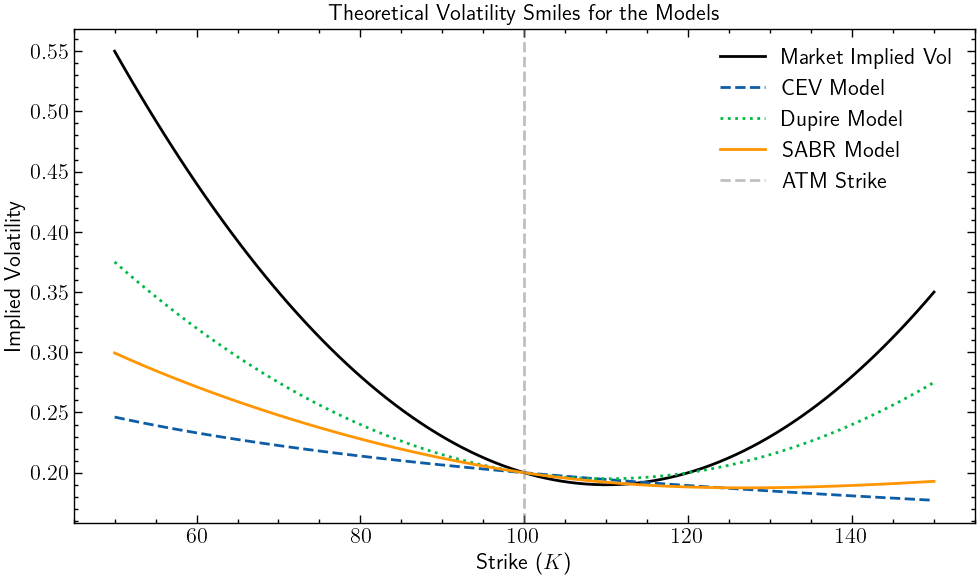

In [301]:
import numpy as np
import matplotlib.pyplot as plt

# Define strike prices
K = np.linspace(50, 150, 100)
F = 100  # Forward price
T = 1.0  # Maturity


# Define a synthetic "market implied volatility" surface to compare with models
def market_iv(K, F, sigma_atm=0.2, skew=-0.002, smile_depth=0.0001):
    return sigma_atm + skew * (K - F) + smile_depth * (K - F)**2

# CEV model implied volatility approximation (simple skew effect)
def cev_iv(K, F, sigma0=0.2, beta=0.7):
    return sigma0 * (K / F) ** (beta - 1)

# Dupire model (example of exact fitting to a synthetic smile)
def dupire_iv(K, F, sigma_atm=0.2, skew=-0.001, curvature=0.00005):
    return sigma_atm + skew * (K - F) + curvature * (K - F) ** 2

# SABR model implied vol using Hagan's approximation (for beta = 1 case)
def sabr_iv(K, F, T, alpha=0.2, beta=1.0, rho=-0.4, nu=0.5):
    if K == F:
        term1 = (alpha / F**(1 - beta))
        term2 = 1 + ((1 - beta)**2 / 24) * (alpha**2 / F**(2 - 2 * beta)) * T \
                + (rho * beta * nu * alpha / (4 * F**(1 - beta))) * T \
                + ((2 - 3 * rho**2) * nu**2 / 24) * T
        return term1 * term2
    else:
        z = (nu / alpha) * (F * K)**((1 - beta) / 2) * np.log(F / K)
        x_z = np.log((np.sqrt(1 - 2 * rho * z + z**2) + z - rho) / (1 - rho))
        term1 = alpha / ((F * K)**((1 - beta) / 2) * (1 + ((1 - beta)**2 / 24) * (np.log(F / K))**2))
        term2 = z / x_z
        return term1 * term2

# Compute implied volatilities
cev_vols = cev_iv(K, F)
dupire_vols = dupire_iv(K, F)
sabr_vols = np.array([sabr_iv(k, F, T) for k in K])
market_vols = market_iv(K, F)

# Plot all volatility smiles including market data
import scienceplots
plt.style.use(['science', 'notebook', 'grid'])
plt.rcParams['text.usetex'] = True
plt.figure(figsize=(10, 6))
plt.plot(K, market_vols, label="Market Implied Vol", color='black', linewidth=2)
plt.plot(K, cev_vols, label="CEV Model", linestyle="--")
plt.plot(K, dupire_vols, label="Dupire Model", linestyle=":")
plt.plot(K, sabr_vols, label="SABR Model", linestyle="-")
plt.axvline(F, color='gray', linestyle='--', alpha=0.5, label="ATM Strike")
plt.xlabel("Strike ($K$)")
plt.ylabel("Implied Volatility")
plt.title("Theoretical Volatility Smiles for the Models")
plt.legend(frameon = False)
plt.grid(False)
plt.tight_layout()
plt.show()


## 1. Constant Elasticity of Variance (CEV) Model

### Formula:
The CEV model specifies the following dynamics for the underlying asset price $S_t$:

$$
dS_t = \mu S_t dt + \sigma S_t^{\beta-1} dW_t
$$

where:
- $\mu$ is the drift rate
- $\sigma$ is the volatility parameter
- $\beta$ is the elasticity factor ($0 < \beta \leq 1$)
- $W_t$ is a Wiener process

### Rationale:
The CEV model captures the leverage effect where volatility increases as the asset price decreases (when $\beta < 1$). It generalizes:
- Geometric Brownian Motion when $\beta = 1$
- Square-root diffusion when $\beta = 0.5$

### Limitations:
1. Constant elasticity assumption may not hold for all assets
2. Cannot reproduce the full volatility surface
3. Difficult to calibrate to market prices for $\beta$ far from 1

Calibrating CEV model with r = 0.0439
Calibrated base volatility: 1.5000
Calibrated beta:             0.2067


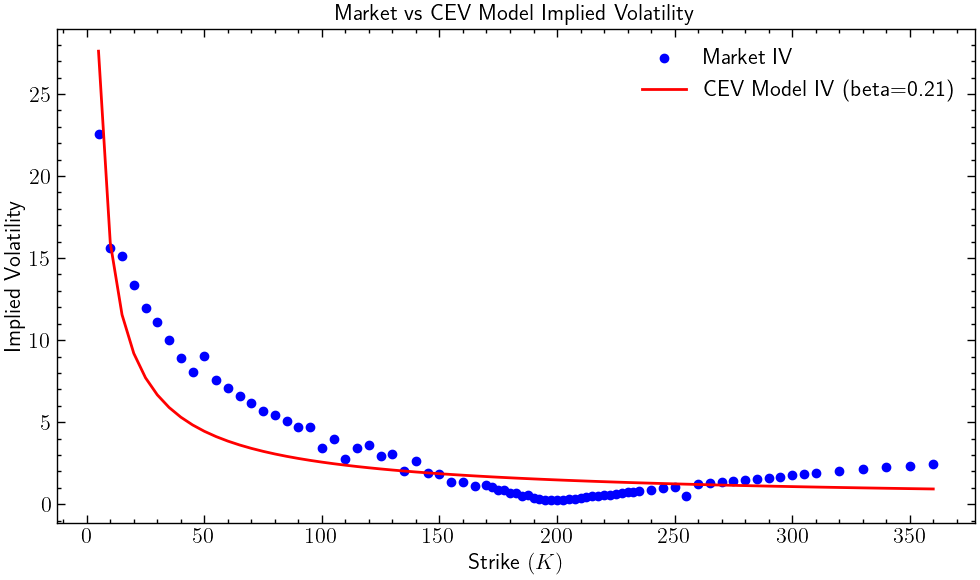

In [302]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize


# CEV Implied Volatility (Analytical)
def cev_implied_volatility(strike, forward_price, base_volatility, beta):
    return base_volatility * (strike / forward_price) ** (beta - 1)


# Calibration of CEV Parameters
def calibrate_cev_model(strikes, market_ivs, forward_price):
    def objective(params):
        base_vol, beta = params
        model_ivs = cev_implied_volatility(strikes, forward_price, base_vol, beta)
        return np.sqrt(np.mean((model_ivs - market_ivs) ** 2))
    bounds = [(0.01, 1.5), (0.1, 1.5)]
    result = minimize(objective, x0=[0.2, 0.9], bounds=bounds)
    return result.x if result.success else (0.2, 1.0)

# Extracting Option Data
ticker_symbol = "AAPL"
option_ticker = yf.Ticker(ticker_symbol)
spot_price = option_ticker.history(period="1d")["Close"].iloc[-1]

# using current 10‑year U.S. Treasury yield (~4.39%) for risk free rate
risk_free_rate = 0.0439

expiry_date = option_ticker.options[0]
expiry_datetime = pd.to_datetime(expiry_date)
time_to_maturity = (expiry_datetime - pd.Timestamp.today()).days / 365

calls = option_ticker.option_chain(expiry_date).calls.copy()
calls = calls.dropna(subset=["impliedVolatility"])
calls = calls[calls["impliedVolatility"] > 0]
calls = calls.sort_values("strike")

strike_prices = calls["strike"].values
market_ivs = calls["impliedVolatility"].values

# Forward price
forward_price = spot_price * np.exp(risk_free_rate * time_to_maturity)


# Calibrating the params and calculating iv
print("Calibrating CEV model with r =", risk_free_rate)
base_volatility, beta = calibrate_cev_model(strike_prices, market_ivs, forward_price)
print(f"Calibrated base volatility: {base_volatility:.4f}")
print(f"Calibrated beta:             {beta:.4f}")

cev_ivs = cev_implied_volatility(strike_prices, forward_price, base_volatility, beta)


# plotting the results
import scienceplots
plt.style.use(['science', 'notebook', 'grid'])
plt.rcParams['text.usetex'] = True
plt.figure(figsize=(10, 6))
plt.scatter(strike_prices, market_ivs, label="Market IV", color="blue")
plt.plot(strike_prices, cev_ivs, label=f"CEV Model IV  (beta={beta:.2f})", color="red", linewidth=2)
plt.xlabel("Strike $(K)$")
plt.ylabel("Implied Volatility")
plt.title('Market vs CEV Model Implied Volatility')
plt.legend(frameon = False)
plt.grid(False)
plt.tight_layout()
plt.show()

## 2. Dupire's Local Volatility Model

### Formula:
Dupire's formula computes the local volatility surface $\sigma_{LV}(S,t)$ from market prices:


$$
\sigma_{\text{LV}}^2(K, T) = \frac{2 \left( \frac{\partial C}{\partial T} + (r - q)K \frac{\partial C}{\partial K} + q C \right)}{K^2 \frac{\partial^2 C}{\partial K^2}}
$$

Where:

- $ C(K, T)$ = European call option price  
- $r$ = risk-free rate  
- $q$ = dividend yield  
- $\frac{\partial C}{\partial T}$ = partial derivative of price w.r.t. time  
- $\frac{\partial C}{\partial K}$ = first partial derivative of price w.r.t. strike  
- $\frac{\partial^2 C}{\partial K^2} $= second partial derivative w.r.t. strike



### Rationale:
1. Provides exact fit to market prices by construction
2. Derives unique deterministic volatility function from option prices
3. Enables pricing of exotic options consistent with vanilla options

### Limitations:
1. Requires smooth, arbitrage-free input prices
2. Needs entire implied volatility surface and numerical stability
4. Sometimes predicts unrealistic dynamics for future volatility

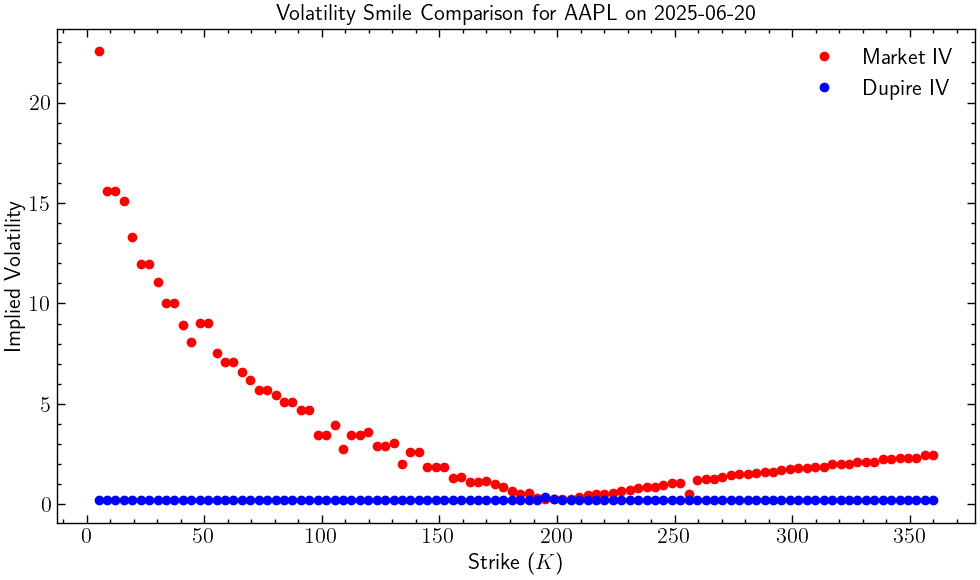

In [303]:
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.optimize import minimize
from scipy.stats import norm
from scipy.interpolate import UnivariateSpline
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


# Get Option Chain Data

ticker = "AAPL"
opt = yf.Ticker(ticker)
S = opt.history(period="1d")["Close"].iloc[-1]
r = 0.0439
q = 0.006   # Dividend yield (approx for AAPL)

# Get the next expiry date
expiry_list = opt.options
expiry = next(e for e in expiry_list if pd.to_datetime(e) > pd.Timestamp.now())
expiry_datetime = pd.to_datetime(expiry)
T = (expiry_datetime - pd.Timestamp.now()).total_seconds() / (365 * 24 * 3600)

opt_chain = opt.option_chain(expiry)
calls = opt_chain.calls
calls = calls[calls['lastPrice'] > 0]
calls = calls[['strike', 'lastPrice', 'impliedVolatility']].dropna()
calls = calls.sort_values('strike')

K_vals = calls['strike'].values
prices = calls['lastPrice'].values
market_ivs = calls['impliedVolatility'].values


# Smooth Price Surface and Estimate Derivatives
spline = UnivariateSpline(K_vals, prices, k=3, s=1.0)
grid_K = np.linspace(min(K_vals), max(K_vals), 100)
call_prices_interp = spline(grid_K)
dC_dK = spline.derivative(n=1)(grid_K)
d2C_dK2 = spline.derivative(n=2)(grid_K)

# Estimate ∂C/∂T via finite differences using Black-Scholes prices
eps = 1e-4

def bs_price_call(S, K, T, r, sigma):
    if T <= 0 or sigma <= 0:
        return max(S - K, 0)
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

def dC_dT_estimate(K_vals, prices, T, eps):
    implied_vols = np.interp(K_vals, calls['strike'], market_ivs)
    C_plus = np.array([bs_price_call(S, k, T + eps, r, iv) for k, iv in zip(K_vals, implied_vols)])
    C_minus = np.array([bs_price_call(S, k, T - eps, r, iv) for k, iv in zip(K_vals, implied_vols)])
    return (C_plus - C_minus) / (2 * eps)

dC_dT_vals = dC_dT_estimate(grid_K, call_prices_interp, T, eps)


# Dupire Local Volatility Calculation
def dupire_local_vol(K, T, dC_dT, dC_dK, d2C_dK2, C, r, q):
    numerator = 2 * (dC_dT + q * C + (r - q) * K * dC_dK)
    denominator = K**2 * d2C_dK2
    sigma_sq = numerator / denominator
    sigma_sq = np.maximum(sigma_sq, 1e-6)
    return np.sqrt(sigma_sq)

local_vols = []
for i in range(len(grid_K)):
    sigma = dupire_local_vol(
        grid_K[i], T,
        dC_dT_vals[i],
        dC_dK[i],
        d2C_dK2[i],
        call_prices_interp[i],
        r,
        q
    )
    local_vols.append(sigma)

local_vols = np.array(local_vols)


# Invert Black-Scholes to get Dupire IVs

def implied_vol_from_price(S, K, T, r, market_price):
    def objective(sigma):
        return (bs_price_call(S, K, T, r, sigma) - market_price) ** 2
    result = minimize(objective, x0=0.2, bounds=[(1e-6, 5)])
    return result.x[0] if result.success else np.nan


# Build DataFrame for Comparison
iv_results = []
for i, K in enumerate(grid_K):
    if np.isnan(local_vols[i]) or local_vols[i] > 5:
        continue
    dupire_price = bs_price_call(S, K, T, r, local_vols[i])
    dupire_iv = implied_vol_from_price(S, K, T, r, dupire_price)

    idx = np.argmin(np.abs(K_vals - K))
    market_price = prices[idx]
    market_iv = market_ivs[idx]
    moneyness = 'ITM' if K < S else ('ATM' if np.isclose(K, S, rtol=0.01) else 'OTM')

    iv_results.append({
        'Strike': K,
        'Market_Price': market_price,
        'Market_IV': market_iv,
        'Dupire_IV': dupire_iv,
        'Moneyness': moneyness
    })

iv_df = pd.DataFrame(iv_results).sort_values('Strike').reset_index(drop=True)


# Plot Volatility Smile
import scienceplots
plt.style.use(['science', 'notebook', 'grid'])
plt.rcParams['text.usetex'] = True
plt.figure(figsize=(10, 6))
plt.plot(iv_df['Strike'], iv_df['Market_IV'], 'ro', label='Market IV')
plt.plot(iv_df['Strike'], iv_df['Dupire_IV'], 'bo', label='Dupire IV')
plt.xlabel("Strike ($K$)")
plt.ylabel("Implied Volatility")
plt.title(f"Volatility Smile Comparison for {ticker} on {expiry}")
plt.legend(frameon = False)
plt.grid(False)
plt.tight_layout()
plt.show()

## 3. SABR Model (Stochastic Alpha Beta Rho)

### Formula:
The SABR model specifies correlated stochastic processes for the forward $F_t$ and volatility $\alpha_t$:

$$
\begin{align*}
dF_t &= \alpha_t F_t^\beta dW_t \\
d\alpha_t &= \nu \alpha_t dZ_t \\
dW_t dZ_t &= \rho dt
\end{align*}
$$

where:
- $\beta$ is the skew parameter ($0 \leq \beta \leq 1$)
- $\nu$ is the volatility of volatility
- $\rho$ is the correlation parameter

### Rationale:
1. Captures stochastic volatility effects
2. Provides closed-form approximation for implied volatility
3. Parameters have intuitive economic interpretation

### Limitations:
1. Approximate formulas break down for long maturities
2. Difficult to calibrate for very low strikes
3. Stationary volatility assumption may not hold

Calibrated SABR parameters:
 alpha=3.0000, beta=0.9838, rho=-0.9999, nu=3.0000


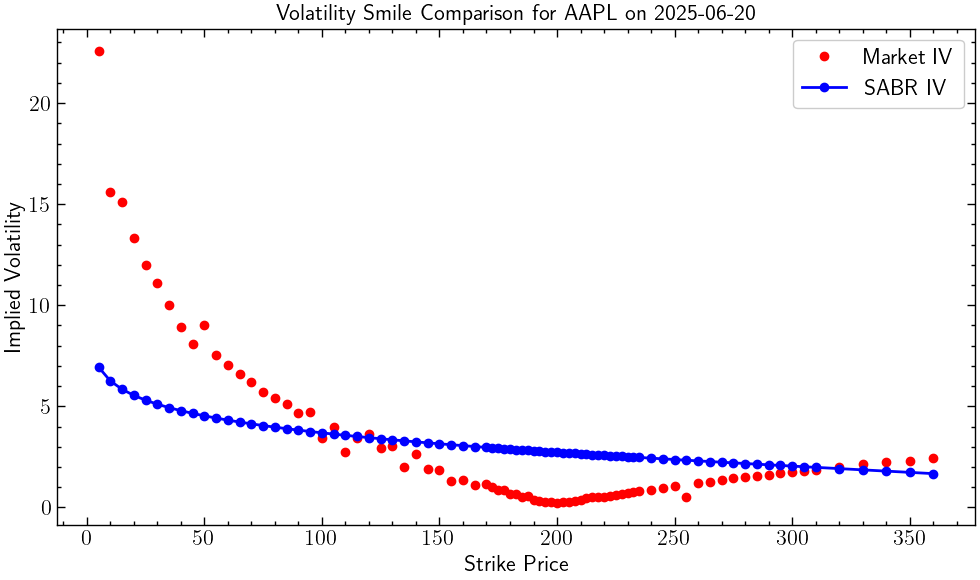

In [304]:
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.optimize import minimize
import warnings
warnings.filterwarnings("ignore")

# SABR implied volatility formula
def sabr_vol(F, K, T, alpha, beta, rho, nu, tol=1e-8):
    if abs(F - K) < tol:
        term1 = alpha / (F**(1 - beta))
        term2 = 1 + (
            ((1 - beta)**2 * alpha**2) / (24 * F**(2 - 2*beta)) +
            (rho * beta * nu * alpha) / (4 * F**(1 - beta)) +
            (nu**2 * (2 - 3 * rho**2)) / 24
        ) * T
        return term1 * term2
    else:
        logFK = np.log(F / K)
        FK_beta = (F * K)**((1 - beta) / 2)
        z = (nu / alpha) * FK_beta * logFK
        x_z = np.log((np.sqrt(1 - 2 * rho * z + z**2) + z - rho) / (1 - rho))
        denom = FK_beta * (1 + ((1 - beta)**2 / 24) * logFK**2 + ((1 - beta)**4 / 1920) * logFK**4)
        vol = (alpha / denom) * (z / x_z) * (
            1 + (
                ((1 - beta)**2 * alpha**2) / (24 * FK_beta**2) +
                (rho * beta * nu * alpha) / (4 * FK_beta) +
                (nu**2 * (2 - 3 * rho**2)) / 24
            ) * T
        )
        return vol

# Load option data
ticker = "AAPL"
opt = yf.Ticker(ticker)
S = opt.history(period="1d")["Close"].iloc[-1]
r = 0.0439
expiry = opt.options[0]
T = (pd.to_datetime(expiry) - pd.Timestamp.today()).days / 365

# Forward price (important for SABR)
F = S * np.exp(r * T)

calls = opt.option_chain(expiry).calls
calls = calls[(calls['lastPrice'] > 0) & (~calls['impliedVolatility'].isna())]
calls = calls[['strike', 'lastPrice', 'impliedVolatility']].dropna()

strikes = calls['strike'].values
market_vols = calls['impliedVolatility'].values

# SABR calibration objective now calibrates alpha, beta, rho, nu
def sabr_objective(params, F, K, T, market_vols):
    alpha, beta, rho, nu = params
    if not (0 < beta < 1):
        return np.inf
    try:
        model_vols = [sabr_vol(F, k, T, alpha, beta, rho, nu) for k in K]
        return np.mean((np.array(model_vols) - np.array(market_vols))**2)
    except Exception:
        return np.inf


# Initial guess and bounds: alpha, beta, rho, nu
x0 = [0.3, 0.5, 0.0, 0.5]
bounds = [(1e-5, 3),   # alpha
          (1e-3, 0.9999), # beta strictly between 0 and 1
          (-0.9999, 0.9999), # rho
          (1e-5, 3)]     # nu


result = minimize(sabr_objective, x0, args=(F, strikes, T, market_vols), bounds=bounds, method='L-BFGS-B')

alpha_opt, beta_opt, rho_opt, nu_opt = result.x

print(f"Calibrated SABR parameters:\n alpha={alpha_opt:.4f}, beta={beta_opt:.4f}, rho={rho_opt:.4f}, nu={nu_opt:.4f}")

# Build iv_df with model IVs
iv_results = []
for _, row in calls.iterrows():
    K = row['strike']
    market_price = row['lastPrice']
    market_iv = row['impliedVolatility']
    sabr_iv = sabr_vol(F, K, T, alpha_opt, beta_opt, rho_opt, nu_opt)
    moneyness = 'ITM' if K < S else ('ATM' if K == S else 'OTM')

    iv_results.append({
        'Strike': K,
        'Price': market_price,
        'Market_IV': market_iv,
        'SABR_IV': sabr_iv,
        'Moneyness': moneyness
    })

iv_df = pd.DataFrame(iv_results).dropna().sort_values(by='Strike')
iv_df.head()


# Plot Volatility Smile
plt.style.use(['science', 'notebook', 'grid'])
plt.rcParams['text.usetex'] = True
plt.figure(figsize=(10, 6))
plt.plot(iv_df['Strike'], iv_df['Market_IV'], 'ro', label='Market IV')
plt.plot(iv_df['Strike'], iv_df['SABR_IV'], 'b-o', label='SABR IV')
plt.xlabel("Strike Price")
plt.ylabel("Implied Volatility")
plt.title(f"Volatility Smile Comparison for {ticker} on {expiry}")
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()

## Combining CEV, Dupire, and SABR Models

In [305]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize, brentq
from scipy.interpolate import UnivariateSpline
from scipy.stats import norm
import warnings
warnings.filterwarnings("ignore")

# -------------------------------
# Front Matters & Data Preparation
# -------------------------------
ticker = "AAPL"
opt = yf.Ticker(ticker)
S = opt.history(period="1d")["Close"].iloc[-1]
expiry = opt.options[0]
expiry_datetime = pd.to_datetime(expiry)
T = (expiry_datetime - pd.Timestamp.today()).days / 365
r = 0.0439
q = 0.0  # For simplicity assuming 0
F = S * np.exp((r - q) * T)

calls = opt.option_chain(expiry).calls
calls = calls[(calls['lastPrice'] > 0) & (~calls['impliedVolatility'].isna())]
calls = calls[['strike', 'lastPrice', 'impliedVolatility']].dropna().sort_values(by='strike')
strikes = calls['strike'].values
market_prices = calls['lastPrice'].values
market_ivs = calls['impliedVolatility'].values

# -------------------------------
# CEV Model
# -------------------------------
def cev_iv(strike, F, base_vol, beta):
    return base_vol * (strike / F) ** (beta - 1)

def calibrate_cev(strikes, market_ivs, F):
    def objective(params):
        base_vol, beta = params
        model_ivs = cev_iv(strikes, F, base_vol, beta)
        return np.sqrt(np.mean((model_ivs - market_ivs) ** 2))
    result = minimize(objective, [0.2, 0.9], bounds=[(0.01, 1.5), (0.1, 1.5)])
    return result.x if result.success else (0.2, 1.0)

base_vol, beta = calibrate_cev(strikes, market_ivs, F)
cev_ivs = cev_iv(strikes, F, base_vol, beta)

# -------------------------------
# Black-Scholes Functions
# -------------------------------
def bs_price_call(S, K, T, r, sigma):
    if T <= 0 or sigma <= 0:
        return max(S - K, 0)
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

def implied_vol(S, K, T, r, market_price):
    def objective(sigma):
        return bs_price_call(S, K, T, r, sigma) - market_price
    try:
        return brentq(objective, 1e-5, 3.0)
    except (ValueError, RuntimeError):
        return np.nan

bs_ivs = np.array([implied_vol(S, k, T, r, p) for k, p in zip(strikes, market_prices)])

# -------------------------------
# Dupire Local Volatility
# -------------------------------
spline = UnivariateSpline(strikes, market_prices, k=3, s=1.0)
grid_K = np.linspace(min(strikes), max(strikes), 100)
call_prices_interp = spline(grid_K)
dC_dK = spline.derivative(n=1)(grid_K)
d2C_dK2 = spline.derivative(n=2)(grid_K)

eps = 1e-4
def dC_dT_estimate(K_vals, T, eps):
    implied_vols = np.interp(K_vals, strikes, market_ivs)
    C_plus = np.array([bs_price_call(S, k, T + eps, r, iv) for k, iv in zip(K_vals, implied_vols)])
    C_minus = np.array([bs_price_call(S, k, T - eps, r, iv) for k, iv in zip(K_vals, implied_vols)])
    return (C_plus - C_minus) / (2 * eps)

dC_dT_vals = dC_dT_estimate(grid_K, T, eps)

def dupire_local_vol(K, T, dC_dT, dC_dK, d2C_dK2, C, r, q):
    numerator = 2 * (dC_dT + q * C + (r - q) * K * dC_dK)
    denominator = K**2 * d2C_dK2
    sigma_sq = numerator / denominator
    sigma_sq = np.maximum(sigma_sq, 1e-6)
    return np.sqrt(sigma_sq)

local_vols = np.array([
    dupire_local_vol(k, T, dT, d1, d2, c, r, q)
    for k, dT, d1, d2, c in zip(grid_K, dC_dT_vals, dC_dK, d2C_dK2, call_prices_interp)
])

def implied_vol_from_price(S, K, T, r, market_price):
    def objective(sigma):
        return (bs_price_call(S, K, T, r, sigma) - market_price) ** 2
    result = minimize(objective, x0=0.2, bounds=[(1e-6, 5)])
    return result.x[0] if result.success else np.nan

dupire_ivs = np.array([
    implied_vol_from_price(S, k, T, r, bs_price_call(S, k, T, r, lv)) if not np.isnan(lv) and lv < 3 else np.nan
    for k, lv in zip(grid_K, local_vols)
])

# -------------------------------
# SABR Model
# -------------------------------
def sabr_iv(F, K, T, alpha, beta, rho, nu, tol=1e-8):
    if abs(F - K) < tol:
        term1 = alpha / (F**(1 - beta))
        term2 = 1 + (((1 - beta)**2 * alpha**2) / (24 * F**(2 - 2*beta)) +
                     (rho * beta * nu * alpha) / (4 * F**(1 - beta)) +
                     (nu**2 * (2 - 3 * rho**2)) / 24) * T
        return term1 * term2
    else:
        logFK = np.log(F / K)
        FK_beta = (F * K)**((1 - beta) / 2)
        z = (nu / alpha) * FK_beta * logFK
        x_z = np.log((np.sqrt(1 - 2 * rho * z + z**2) + z - rho) / (1 - rho))
        denom = FK_beta * (1 + ((1 - beta)**2 / 24) * logFK**2 + ((1 - beta)**4 / 1920) * logFK**4)
        return (alpha / denom) * (z / x_z) * (
            1 + (((1 - beta)**2 * alpha**2) / (24 * FK_beta**2) +
                 (rho * beta * nu * alpha) / (4 * FK_beta) +
                 (nu**2 * (2 - 3 * rho**2)) / 24) * T)

def sabr_objective(params, F, K, T, market_vols):
    alpha, beta, rho, nu = params
    if not (0 < beta < 1): return np.inf
    try:
        model_vols = [sabr_iv(F, k, T, alpha, beta, rho, nu) for k in K]
        return np.mean((np.array(model_vols) - np.array(market_vols)) ** 2)
    except: return np.inf

sabr_bounds = [(1e-5, 3), (1e-3, 0.9999), (-0.9999, 0.9999), (1e-5, 3)]
sabr_init = [0.3, 0.5, 0.0, 0.5]
sabr_res = minimize(sabr_objective, sabr_init, args=(F, strikes, T, market_ivs), bounds=sabr_bounds)
alpha, beta_sabr, rho, nu = sabr_res.x
sabr_ivs = [sabr_iv(F, k, T, alpha, beta_sabr, rho, nu) for k in strikes]

# -------------------------------
# Final Combined DataFrame
# -------------------------------
iv_df = pd.DataFrame({
    'Strike': strikes,
    'Market_IV': market_ivs,
    'BS_IV': bs_ivs,
    'CEV_IV': cev_ivs,
    'SABR_IV': sabr_ivs
})

dupire_df = pd.DataFrame({'Strike': grid_K, 'Dupire_IV': dupire_ivs})
iv_df = pd.merge_asof(iv_df.sort_values('Strike'), dupire_df.sort_values('Strike'), on='Strike')


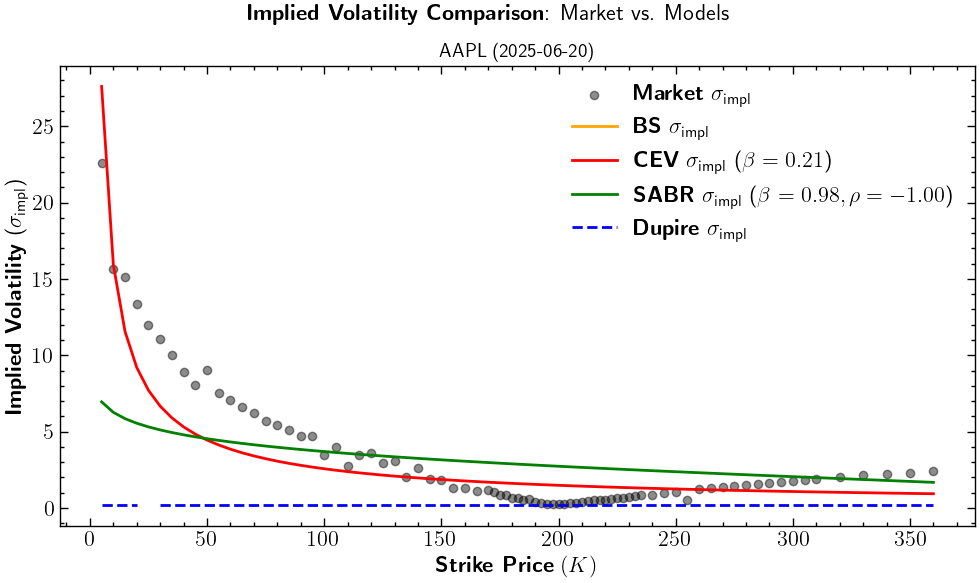

In [306]:
# Plotting the Comparison
plt.style.use(['science', 'notebook', 'grid'])
plt.rcParams['text.usetex'] = True
plt.figure(figsize=(10, 6))
plt.scatter(iv_df['Strike'], iv_df['Market_IV'], label=r'\textbf{Market} $\sigma_\text{impl}$', color='black', alpha=0.45)
plt.plot(iv_df['Strike'], iv_df['BS_IV'], label=r'\textbf{BS} $\sigma_\text{impl}$', color='orange', lw=2)
plt.plot(iv_df['Strike'], iv_df['CEV_IV'], label=rf'\textbf{{CEV}} $\sigma_\text{{impl}}$ ($\beta={beta:.2f}$)', color='red', lw=2)
plt.plot(iv_df['Strike'], iv_df['SABR_IV'], label=rf'\textbf{{SABR}} $\sigma_\text{{impl}}$ ($\beta={beta_sabr:.2f}, \rho={rho:.2f}$)', color='green', lw=2)
plt.plot(iv_df['Strike'], iv_df['Dupire_IV'], label=r'\textbf{Dupire} $\sigma_\text{impl}$', color='blue', lw=2, linestyle='dashed')
plt.xlabel(r'\textbf{Strike Price} $(K)$')
plt.ylabel(r'\textbf{Implied Volatility} ($\sigma_\text{impl}$)')
plt.suptitle(r'\textbf{Implied Volatility Comparison}: Market vs. Models', fontsize=16)
plt.title(f'{ticker} ({expiry})', fontsize=14)
plt.legend(frameon=False)
plt.tight_layout()
plt.grid(False)
plt.show()


## Smoothing Volatility Smile Curves

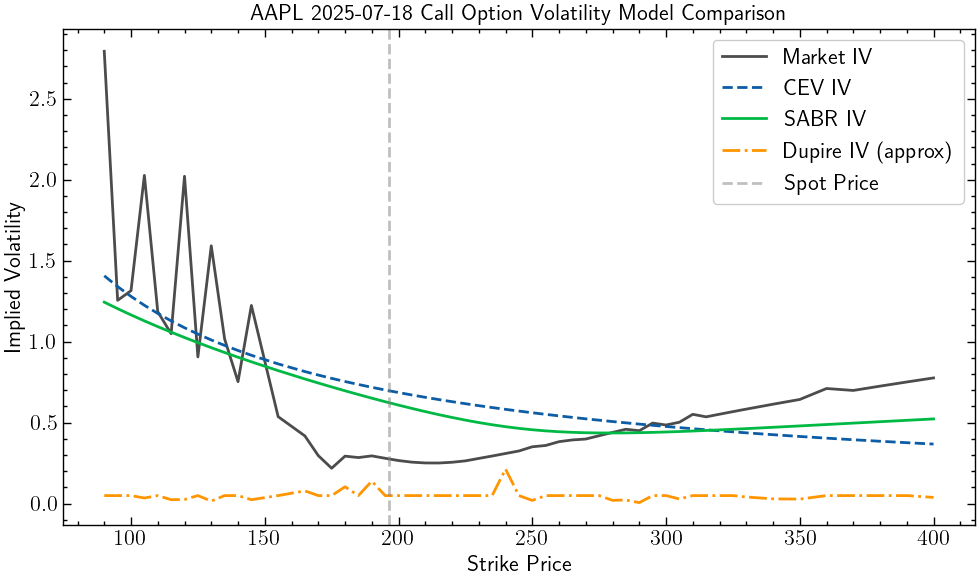


Raw RMSE Errors:
CEV Model RMSE: 0.37818
SABR Model RMSE: 0.36247
Dupire Model RMSE (approx): 0.79688


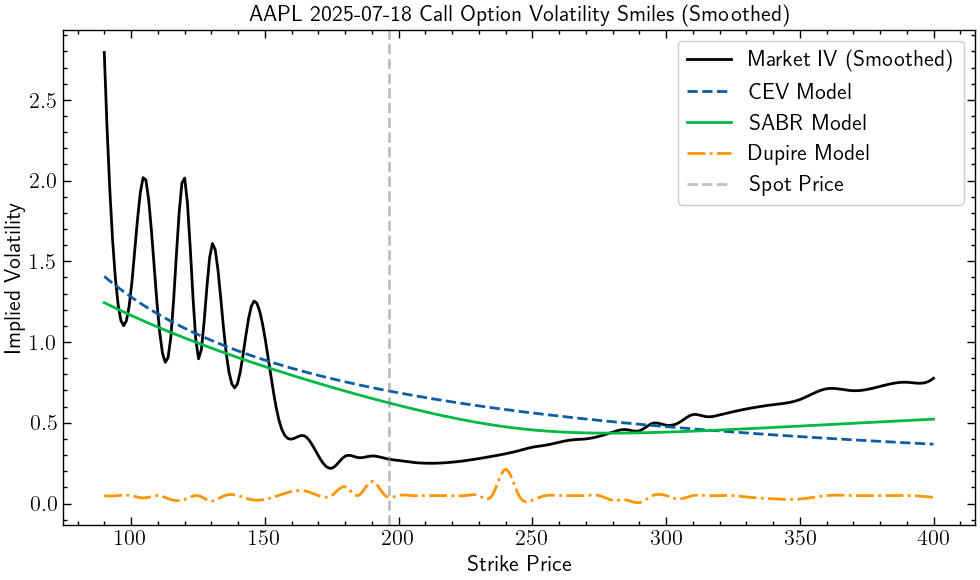


Smoothed IV Curve RMSE Comparison:
CEV Model RMSE (Smoothed): 0.33405
SABR Model RMSE (Smoothed): 0.30371
Dupire Model RMSE (Smoothed): 0.73717


In [307]:
import yfinance as yf
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.optimize import minimize, brentq
from scipy.stats import norm
from scipy.interpolate import interp1d, UnivariateSpline

# Step 1: Fetch AAPL option chain and market data
ticker = 'AAPL'
expiry = '2025-07-18'
asset = yf.Ticker(ticker)
calls = asset.option_chain(expiry).calls

# Get underlying price and set risk-free rate
S0 = asset.history(period='1d')['Close'].iloc[-1]
r = 0.0439
today = datetime.now().date()
T_days = (pd.to_datetime(expiry).date() - today).days
T = T_days / 365
calls['T'] = T

# Step 2: Black-Scholes pricing and implied volatility
def bs_price_call(S, K, T, r, sigma):
    if T == 0:
        return max(S-K, 0)
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

def implied_volatility_call(mkt_price, S, K, T, r):
    def f(sigma): return bs_price_call(S, K, T, r, sigma) - mkt_price
    try:
        return brentq(f, 1e-6, 5)
    except:
        return np.nan

# Market IV calculation
calls['iv_market'] = calls.apply(
    lambda row: implied_volatility_call(row['lastPrice'], S0, row['strike'], row['T'], r), axis=1
)
calls.dropna(subset=['iv_market'], inplace=True)

# Step 3: Model IV functions
def cev_iv(K, F, sigma0, beta):
    return sigma0 * (K / F)**(beta - 1)

def sabr_iv(K, F, T, alpha, beta, rho, nu):
    if K == F:
        term1 = alpha / F**(1 - beta)
        term2 = 1 + ((1 - beta)**2 / 24) * (alpha**2 / F**(2 - 2 * beta)) * T \
                + (rho * beta * nu * alpha / (4 * F**(1 - beta))) * T \
                + ((2 - 3 * rho**2) * nu**2 / 24) * T
        return term1 * term2
    else:
        z = (nu / alpha) * (F * K)**((1 - beta) / 2) * np.log(F / K)
        x_z = np.log((np.sqrt(1 - 2 * rho * z + z**2) + z - rho) / (1 - rho))
        denom = (F * K)**((1 - beta) / 2)
        return (alpha / denom) * (z / x_z)

# Step 4: Model Calibration
def cev_rmse(params):
    sigma0, beta = params
    F = S0 * np.exp(r * T)
    model_iv = cev_iv(calls.strike.values, F, sigma0, beta)
    return np.sqrt(np.nanmean((model_iv - calls.iv_market.values) ** 2))

def sabr_rmse(params):
    alpha, beta, rho, nu = params
    model_iv = np.array([sabr_iv(K, S0, T, alpha, beta, rho, nu) for K in calls.strike])
    return np.sqrt(np.nanmean((model_iv - calls.iv_market.values) ** 2))

res_cev = minimize(cev_rmse, x0=[0.2, 0.7], bounds=[(0.01, 1), (0.1, 1)])
sigma0_cev, beta_cev = res_cev.x

res_sabr = minimize(sabr_rmse, x0=[0.2, 0.7, -0.4, 0.5],
                    bounds=[(0.01, 2), (0.0, 1), (-0.99, 0.99), (0.01, 2)])
alpha_sabr, beta_sabr, rho_sabr, nu_sabr = res_sabr.x

# Step 5: Dupire Local Volatility Approximation
K = calls['strike'].values
C = calls['lastPrice'].values
call_interp = interp1d(K, C, kind='cubic', fill_value='extrapolate')
K_grid = np.linspace(K.min(), K.max(), 1000)
C_grid = call_interp(K_grid)
dK = K_grid[1] - K_grid[0]
C_K = np.gradient(C_grid, dK)
C_KK = np.gradient(C_K, dK)
numerator = r * K_grid * C_K
denominator = 0.5 * (K_grid**2) * C_KK
with np.errstate(divide='ignore', invalid='ignore'):
    sigma_loc2 = numerator / denominator
sigma_loc2 = np.where(sigma_loc2 < 0, np.nan, sigma_loc2)
sigma_loc = np.sqrt(sigma_loc2)
loc_vol_interp = interp1d(K_grid, sigma_loc, bounds_error=False, fill_value=np.nan)
loc_vols = loc_vol_interp(calls['strike'])
mean_loc_vol = np.nanmean(loc_vols)
dupire_iv = np.where(np.isnan(loc_vols), mean_loc_vol, loc_vols)

# Step 6: Compare Model IVs on Raw Market Data
strikes = calls['strike'].values
iv_market = calls['iv_market'].values
F = S0 * np.exp(r * T)
iv_cev = cev_iv(strikes, F, sigma0_cev, beta_cev)
iv_sabr = np.array([sabr_iv(K, S0, T, alpha_sabr, beta_sabr, rho_sabr, nu_sabr) for K in strikes])

# Plot raw smiles
plt.style.use(['science', 'notebook', 'grid'])
plt.rcParams['text.usetex'] = True
plt.figure(figsize=(10, 6))
plt.plot(strikes, iv_market, label='Market IV', linestyle = '-', color='black', alpha=0.7)
plt.plot(strikes, iv_cev, label='CEV IV', linestyle='--', linewidth=2)
plt.plot(strikes, iv_sabr, label='SABR IV', linestyle='-', linewidth=2)
plt.plot(strikes, dupire_iv, label='Dupire IV (approx)', linestyle='-.', linewidth=2)
plt.axvline(S0, color='gray', linestyle='--', alpha=0.5, label='Spot Price')
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
plt.title(f"{ticker} {expiry} Call Option Volatility Model Comparison")
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()

# Raw RMSE
cev_error = cev_rmse([sigma0_cev, beta_cev])
sabr_error = sabr_rmse([alpha_sabr, beta_sabr, rho_sabr, nu_sabr])
dupire_rmse = np.sqrt(np.nanmean((dupire_iv - iv_market) ** 2))
print("\nRaw RMSE Errors:")
print(f"CEV Model RMSE: {cev_error:.5f}")
print(f"SABR Model RMSE: {sabr_error:.5f}")
print(f"Dupire Model RMSE (approx): {dupire_rmse:.5f}")

# Step 7: Smoothed Smile Comparison
K_grid_smooth = np.linspace(strikes.min(), strikes.max(), 300)
market_iv_spline = UnivariateSpline(strikes, iv_market, s=1e-4)
iv_market_smooth = market_iv_spline(K_grid_smooth)
cev_iv_smooth = cev_iv(K_grid_smooth, F, sigma0_cev, beta_cev)
sabr_iv_smooth = np.array([sabr_iv(K, S0, T, alpha_sabr, beta_sabr, rho_sabr, nu_sabr) for K in K_grid_smooth])
dupire_interp = interp1d(strikes, dupire_iv, kind='cubic', fill_value='extrapolate')
dupire_iv_smooth = dupire_interp(K_grid_smooth)

# Smoothed plot
plt.style.use(['science', 'notebook', 'grid'])
plt.rcParams['text.usetex'] = True
plt.figure(figsize=(10, 6))
plt.plot(K_grid_smooth, iv_market_smooth, label='Market IV (Smoothed)', color='black', linestyle = '-', linewidth=2)
plt.plot(K_grid_smooth, cev_iv_smooth, label='CEV Model', linestyle='--', linewidth=2)
plt.plot(K_grid_smooth, sabr_iv_smooth, label='SABR Model', linestyle='-', linewidth=2)
plt.plot(K_grid_smooth, dupire_iv_smooth, label='Dupire Model', linestyle='-.', linewidth=2)
plt.axvline(S0, color='gray', linestyle='--', alpha=0.5, label='Spot Price')
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
plt.title(f"{ticker} {expiry} Call Option Volatility Smiles (Smoothed)")
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()

# Smoothed RMSE
def smoothed_rmse(y_true, y_pred):
    return np.sqrt(np.nanmean((y_true - y_pred) ** 2))

rmse_cev_smooth = smoothed_rmse(iv_market_smooth, cev_iv_smooth)
rmse_sabr_smooth = smoothed_rmse(iv_market_smooth, sabr_iv_smooth)
rmse_dupire_smooth = smoothed_rmse(iv_market_smooth, dupire_iv_smooth)

print("\nSmoothed IV Curve RMSE Comparison:")
print(f"CEV Model RMSE (Smoothed): {rmse_cev_smooth:.5f}")
print(f"SABR Model RMSE (Smoothed): {rmse_sabr_smooth:.5f}")
print(f"Dupire Model RMSE (Smoothed): {rmse_dupire_smooth:.5f}")


# **Volatility Surface**

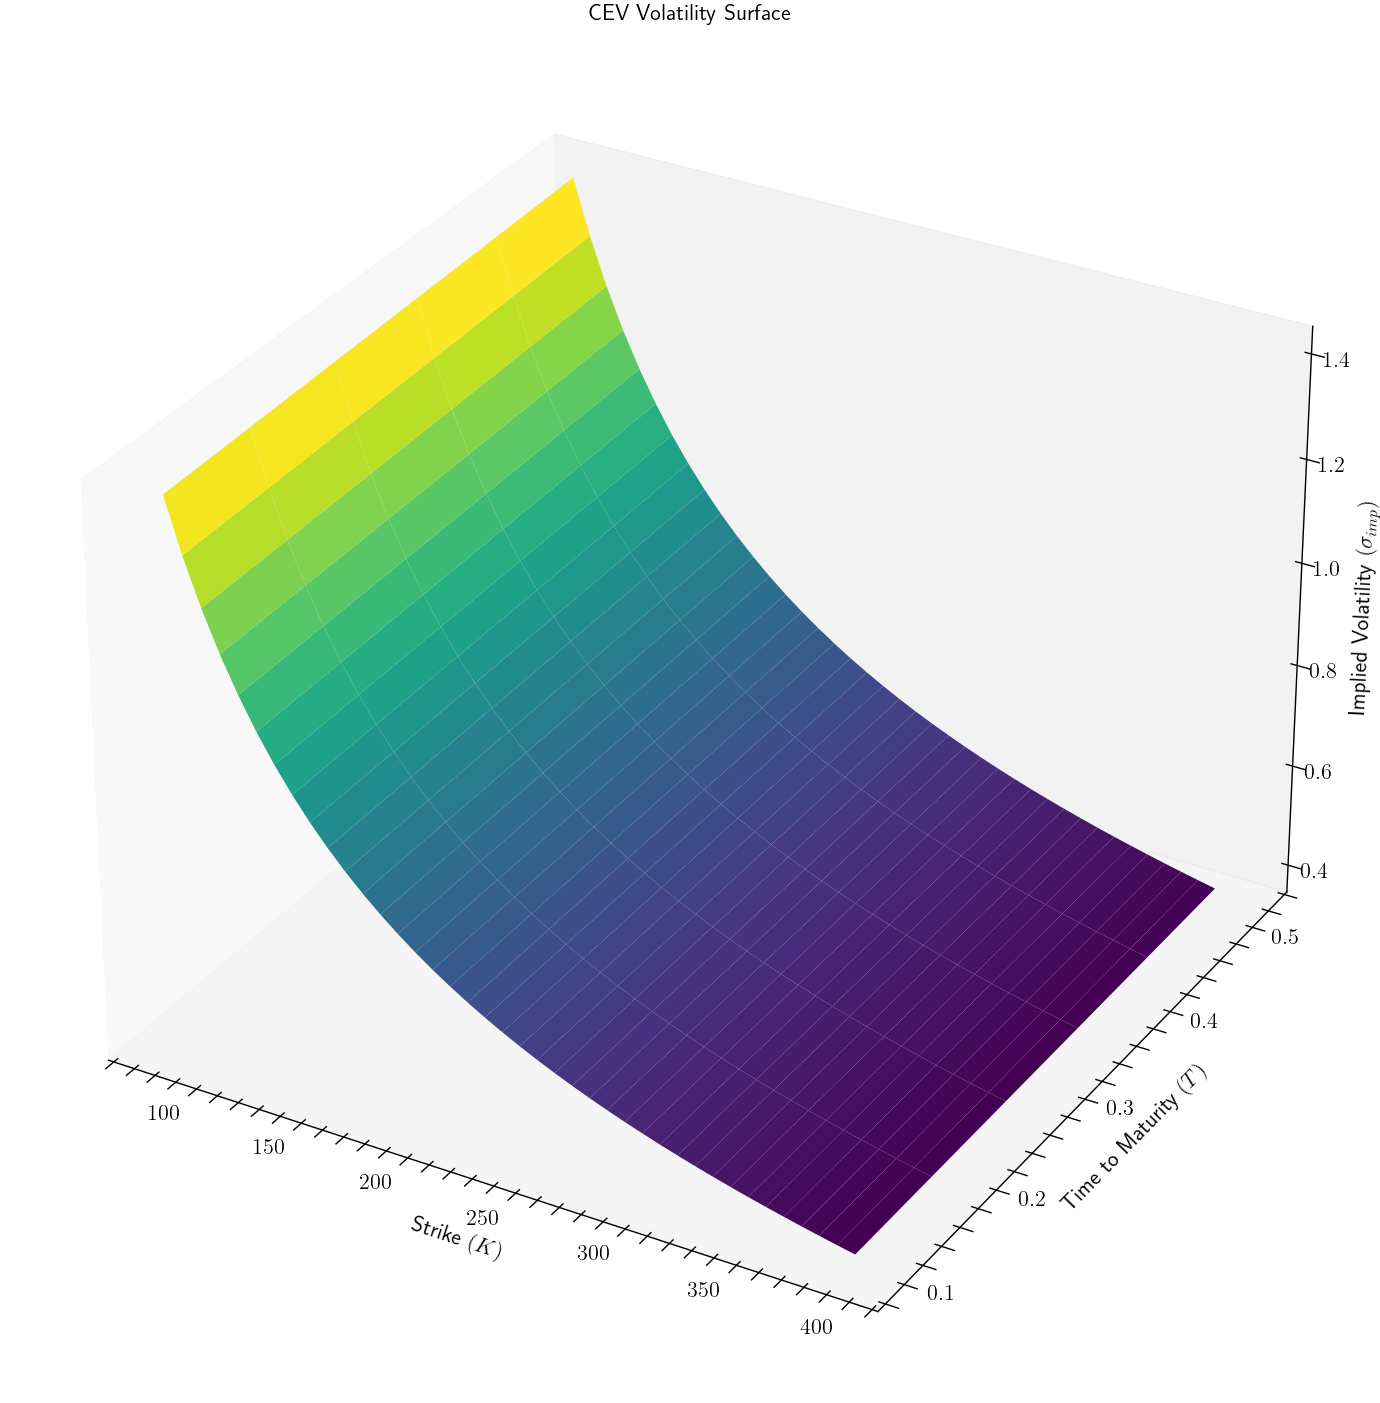

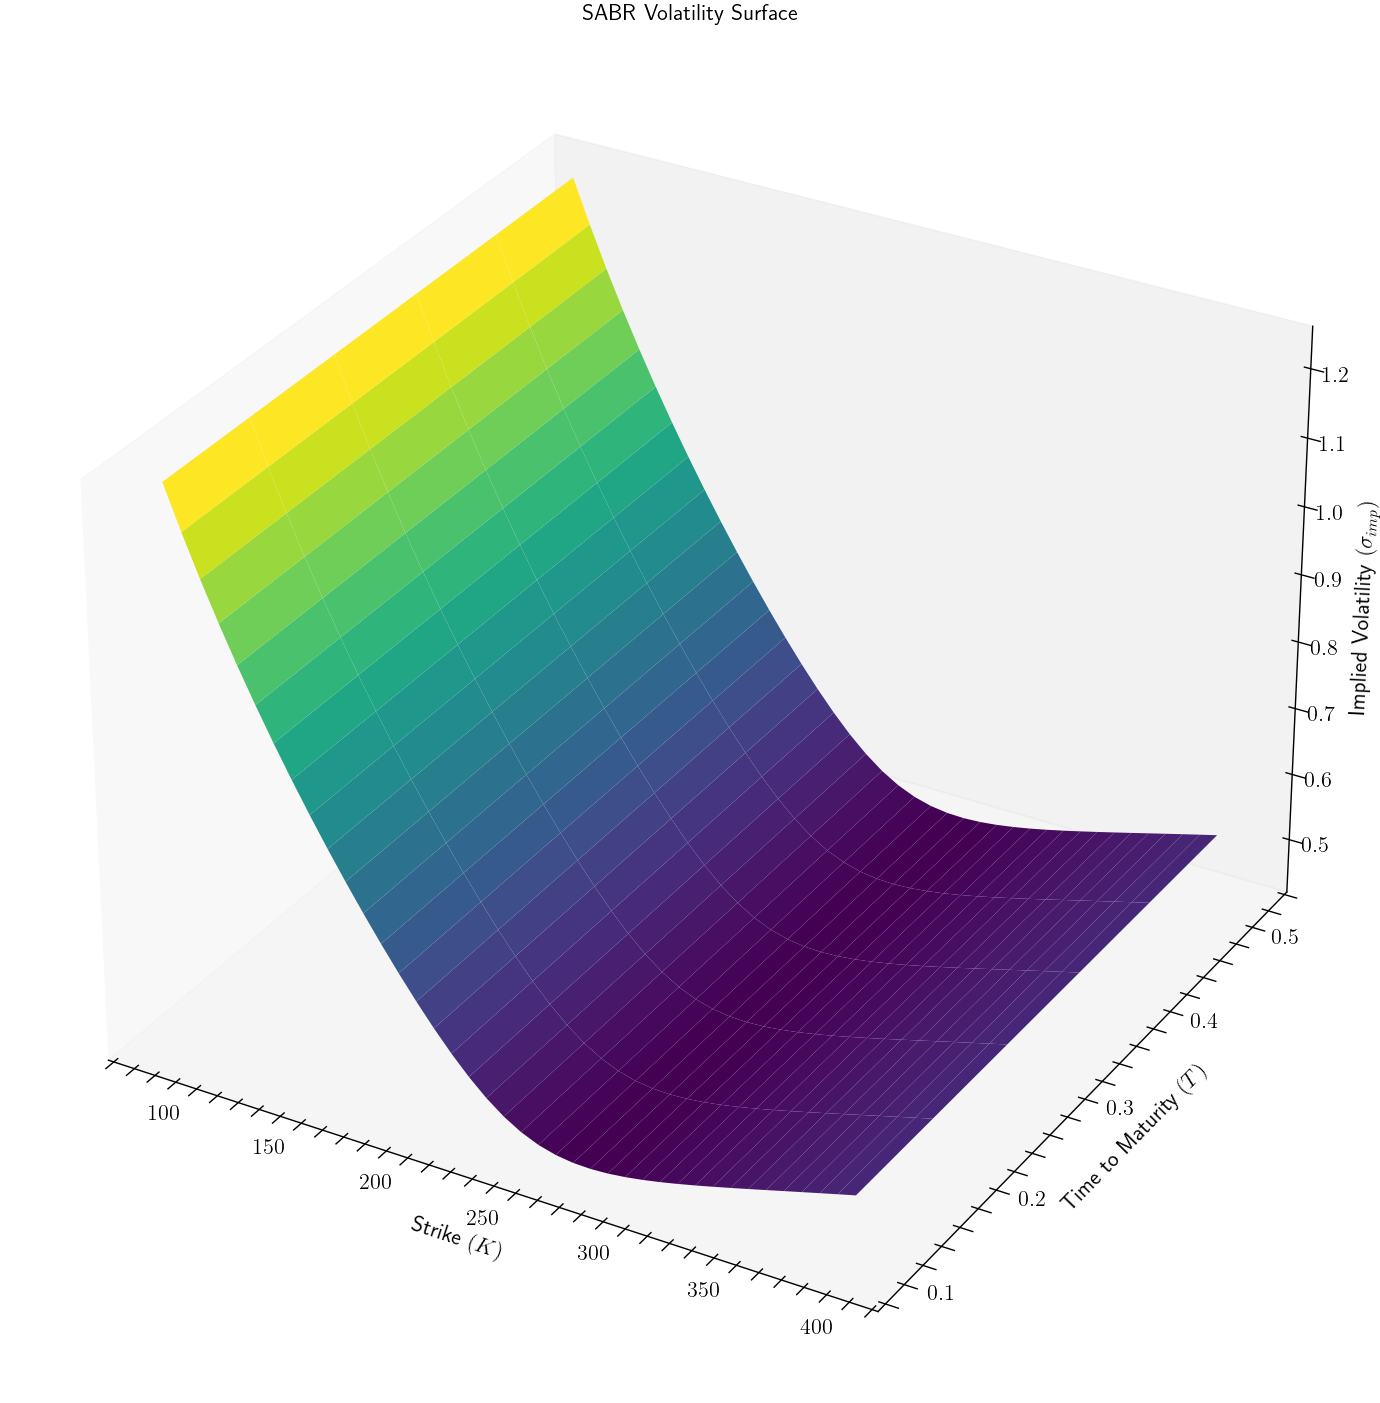

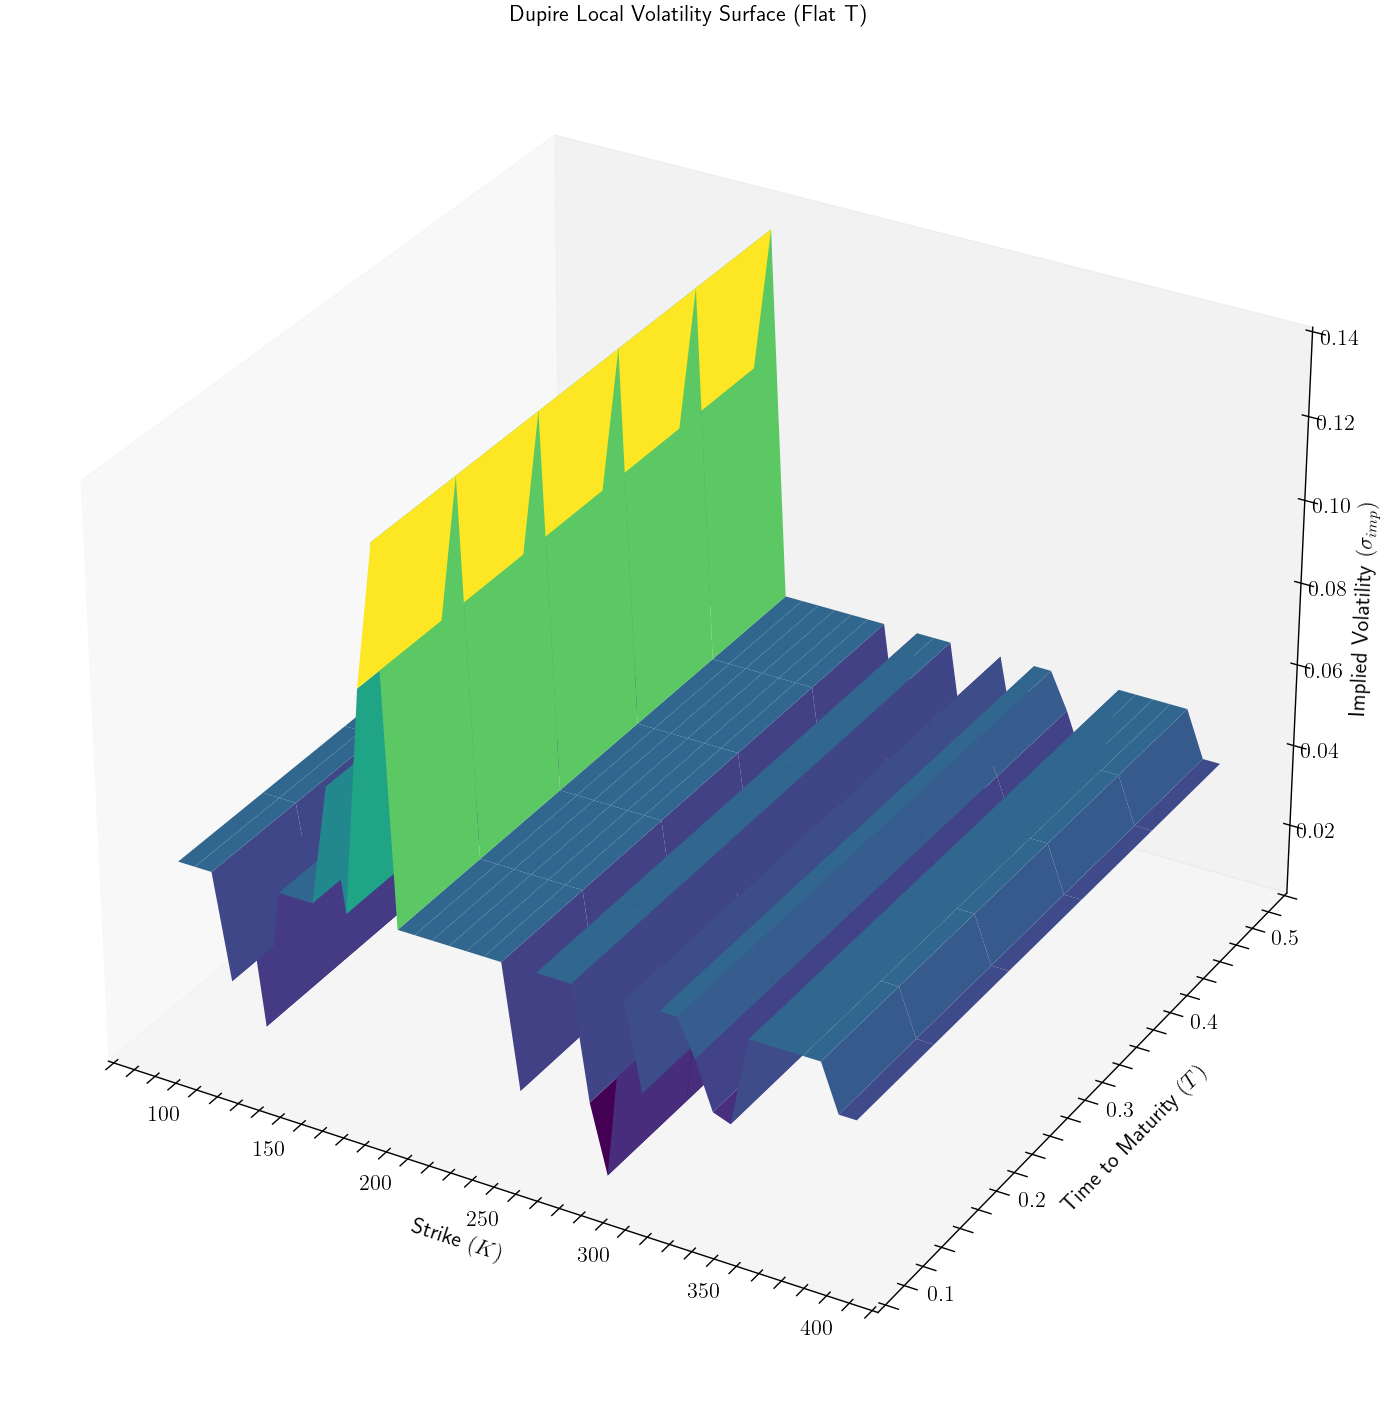

RMSE Errors:
CEV Model RMSE: 0.37818
SABR Model RMSE: 0.36247
Dupire Model RMSE (approx): 0.79688


In [308]:
import yfinance as yf
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from scipy.optimize import minimize, brentq
from scipy.stats import norm
from scipy.interpolate import interp1d, griddata
from mpl_toolkits.mplot3d import Axes3D


# Starting from the beginning to make it easier to follow.

# Fetch AAPL option chain and market data
ticker = 'AAPL'
expiry = '2025-07-18'
asset = yf.Ticker(ticker)
calls = asset.option_chain(expiry).calls

# Market data
S0 = asset.history(period='1d')['Close'].iloc[-1]
r = 0.0439
today = datetime.now().date()
T_days = (pd.to_datetime(expiry).date() - today).days
T = T_days / 365
calls['T'] = T

# Black-Scholes and implied volatility
def bs_price_call(S, K, T, r, sigma):
    if T == 0:
        return max(S-K, 0)
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

def implied_volatility_call(mkt_price, S, K, T, r):
    def f(sigma): return bs_price_call(S, K, T, r, sigma) - mkt_price
    try:
        return brentq(f, 1e-6, 5)
    except:
        return np.nan

# Market IVs
calls['iv_market'] = calls.apply(
    lambda row: implied_volatility_call(row['lastPrice'], S0, row['strike'], row['T'], r), axis=1
)
calls.dropna(subset=['iv_market'], inplace=True)

# CEV and SABR models
def cev_iv(K, F, sigma0, beta):
    return sigma0 * (K / F)**(beta - 1)

def sabr_iv(K, F, T, alpha, beta, rho, nu):
    if K == F:
        term1 = alpha / F**(1 - beta)
        term2 = 1 + ((1 - beta)**2 / 24) * (alpha**2 / F**(2 - 2 * beta)) * T \
                + (rho * beta * nu * alpha / (4 * F**(1 - beta))) * T \
                + ((2 - 3 * rho**2) * nu**2 / 24) * T
        return term1 * term2
    else:
        z = (nu / alpha) * (F * K)**((1 - beta) / 2) * np.log(F / K)
        x_z = np.log((np.sqrt(1 - 2 * rho * z + z**2) + z - rho) / (1 - rho))
        denom = (F * K)**((1 - beta) / 2)
        return (alpha / denom) * (z / x_z)

# Calibrate models
def cev_rmse(params):
    sigma0, beta = params
    F = S0 * np.exp(r * T)
    model_iv = cev_iv(calls.strike.values, F, sigma0, beta)
    return np.sqrt(np.nanmean((model_iv - calls.iv_market.values) ** 2))

def sabr_rmse(params):
    alpha, beta, rho, nu = params
    model_iv = np.array([sabr_iv(K, S0, T, alpha, beta, rho, nu)
                         for K in calls.strike])
    return np.sqrt(np.nanmean((model_iv - calls.iv_market.values) ** 2))

res_cev = minimize(cev_rmse, x0=[0.2, 0.7], bounds=[(0.01, 1), (0.1, 1)])
sigma0_cev, beta_cev = res_cev.x

res_sabr = minimize(sabr_rmse, x0=[0.2, 0.7, -0.4, 0.5],
                    bounds=[(0.01, 2), (0.0, 1), (-0.99, 0.99), (0.01, 2)])
alpha_sabr, beta_sabr, rho_sabr, nu_sabr = res_sabr.x

# Dupire Local Volatility
K = calls['strike'].values
C = calls['lastPrice'].values
call_interp = interp1d(K, C, kind='cubic', fill_value='extrapolate')
K_grid = np.linspace(K.min(), K.max(), 1000)
C_grid = call_interp(K_grid)
dK = K_grid[1] - K_grid[0]
C_K = np.gradient(C_grid, dK)
C_KK = np.gradient(C_K, dK)
numerator = r * K_grid * C_K
denominator = 0.5 * (K_grid**2) * C_KK
with np.errstate(divide='ignore', invalid='ignore'):
    sigma_loc2 = numerator / denominator
sigma_loc2 = np.where(sigma_loc2 < 0, np.nan, sigma_loc2)
sigma_loc = np.sqrt(sigma_loc2)
loc_vol_interp = interp1d(K_grid, sigma_loc, bounds_error=False, fill_value=np.nan)
loc_vols = loc_vol_interp(calls['strike'])
dupire_iv = np.where(np.isnan(loc_vols), np.nanmean(loc_vols), loc_vols)
dupire_rmse = np.sqrt(np.nanmean((dupire_iv - calls.iv_market.values) ** 2))

# Volatility Surfaces
strike_grid = np.linspace(K.min(), K.max(), 40)
maturity_grid = np.array([30, 60, 90, 120, 150, 180]) / 365  # in years
F_grid = lambda T: S0 * np.exp(r * T)

# Initialize surfaces
cev_surface = np.zeros((len(maturity_grid), len(strike_grid)))
sabr_surface = np.zeros_like(cev_surface)
dupire_surface = np.tile(dupire_iv[np.searchsorted(K, strike_grid, side='left')], (len(maturity_grid), 1))

for i, t in enumerate(maturity_grid):
    F_t = F_grid(t)
    cev_surface[i, :] = cev_iv(strike_grid, F_t, sigma0_cev, beta_cev)
    sabr_surface[i, :] = [sabr_iv(Kk, S0, t, alpha_sabr, beta_sabr, rho_sabr, nu_sabr) for Kk in strike_grid]

# Plot 3D volatility surfaces
def plot_surface(X, Y, Z, title):
    import scienceplots
    plt.style.use(['science', 'notebook', 'grid'])
    plt.rcParams['text.usetex'] = True
    fig = plt.figure(figsize=(14, 15))
    ax = fig.add_subplot(111, projection='3d')
    Xg, Yg = np.meshgrid(X, Y)
    ax.plot_surface(Xg, Yg, Z, cmap='viridis', edgecolor='none')
    ax.grid(False)
    ax.set_xlabel('Strike $(K)$', labelpad = 8)
    ax.set_ylabel('Time to Maturity $(T)$', labelpad = 8)
    ax.set_zlabel('Implied Volatility $(\sigma_{imp})$', labelpad = 8)
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

plot_surface(strike_grid, maturity_grid, cev_surface, 'CEV Volatility Surface')
plot_surface(strike_grid, maturity_grid, sabr_surface, 'SABR Volatility Surface')
plot_surface(strike_grid, maturity_grid, dupire_surface, 'Dupire Local Volatility Surface (Flat T)')

# Report RMSE
print("RMSE Errors:")
print(f"CEV Model RMSE: {cev_rmse([sigma0_cev, beta_cev]):.5f}")
print(f"SABR Model RMSE: {sabr_rmse([alpha_sabr, beta_sabr, rho_sabr, nu_sabr]):.5f}")
print(f"Dupire Model RMSE (approx): {dupire_rmse:.5f}")


# **Reflections**

Over the past few weeks, I've been exploring different volatility models—**CEV, Dupire (Local Vol), and SABR**—to understand their strengths, weaknesses, and practical applications. Here's a breakdown of key insights from my experiments, along with areas for improvement.

## 1. CEV (Constant Elasticity of Variance) Model
✅ **Pros:**
- Simple extension of Black-Scholes with a power-law volatility function (σSᵝ)
- Captures leverage effect (negative correlation between price and volatility)

❌ **Shortcomings in Testing:**
- Struggles with extreme short-dated options (0DTE/1DTE) where volatility skew is highly dynamic
- Fixed beta parameter can't adapt to rapidly changing market regimes

🔧 **Improvement:**
- **Time-dependent β** or hybrid approaches (e.g., CEV-SABR) could enhance flexibility

---

## 2. Dupire's Local Volatility Model
✅ **Pros:**
- **Perfectly fits the market smile** by construction (when implemented correctly)
- No-arbitrage guarantees and exact calibration to observed option prices

❌ **Shortcomings in Testing:**
- **Flat local vols in wings** due to numerical instability in derivatives
- **Extreme sensitivity to interpolation**—small pricing errors distort local vol
- **Fails to capture forward vol dynamics** (predicts future smiles poorly)

🔧 **Improvements:**
- **Better smoothing (Savitzky-Golay filter)** for stable derivatives
- **Strictly increasing strike sorting** to avoid interpolation errors
- **Focus on near-ATM for short expiries**, where the model is most reliable

---

## 3. SABR (Stochastic Alpha Beta Rho) Model
✅ **Pros:**
- **Stochastic volatility** component captures vol-of-vol (critical for wings)
- **Analytical approximation (Hagan's formula)** makes it fast and tractable
- **Separates skew (β) and smile (α, ρ, ν)** for better interpretability

❌ **Shortcomings in Testing:**
- **Breaks down at very low strikes** (negative densities possible)
- **Calibration instability** for short expiries (similar to Dupire)

🔧 **Improvement:**
- **Freeze parameters for short maturities** and use **SABR-Hagan-WP** (arbitrage-free correction)
- **Combine with machine learning** for adaptive parameter tuning

---

## Key Takeaways
1. **No single model dominates**—each has trade-offs between fit, stability, and forward dynamics
2. **Dupire works best for short-dated options** with careful numerical treatment
3. **SABR is superior for longer expiries**, but requires safeguards against arbitrage
4. **Hybrid approaches (e.g., Local-Stochastic Vol)** may be the next step for robustness

# **References**

- Black, Fischer; Scholes, Myron (1973). *The Pricing of Options and Corporate Liabilities*. Journal of Political Economy. 81 (3): 637–654. doi:10.1086/260062

- Gatheral, J. (2006). *The volatility surface: a practitioner's guide (Vol. 357)*. John Wiley & Sons.

- Hull, John C. (2008). *Options, Futures and Other Derivatives (7th ed.)*. Prentice Hall. ISBN 978-0-13-505283-9.